In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%cd ..

/Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks


In [3]:
import os
os.environ["USE_PYGEOS"] = "0"

from shapely.geometry import Polygon
import shutil
import geopandas
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd
from napari_spatialdata import Interactive
from spatialdata.transformations import (
    Affine,
    Identity,
    Sequence,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
def corr(X, Y):
    return np.array([pearsonr(x, y)[0] for x, y in zip(X.T, Y.T)])


def pair_pearsonr(x, y, axis=1):
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x - mx, y - my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm * xm).sum(axis=axis) * (ym * ym).sum(axis=axis))
    r = r_num / r_den
    return r

In [5]:
SANDBOX_PATH = "paper_reproducibility/spatialdata-sandbox"
assert os.path.exists(SANDBOX_PATH)
DATA_PATH = os.path.join(SANDBOX_PATH, "generated_data/xenium_visium_integration/")
VISIUM_ADATA_PATH = os.path.join(DATA_PATH, "visium_annotated_cell2location.h5ad")
visium_roi_adata = sc.read(VISIUM_ADATA_PATH)

In [6]:
visium_roi_adata.layers["counts"] = visium_roi_adata.X
xe1_counts = np.sum(visium_roi_adata.layers["xe_rep1_tx"], 0)
visium_counts = np.sum(visium_roi_adata.layers["counts"].toarray(), 0)
xe1_xe2 = pair_pearsonr(
    np.log(visium_roi_adata.layers["xe_rep2_tx"] + 1), np.log(visium_roi_adata.layers["xe_rep1_tx"] + 1), axis=0
)
xe1_vis = pair_pearsonr(
    np.log(visium_roi_adata.layers["counts"].toarray() + 1), np.log(visium_roi_adata.layers["xe_rep1_tx"] + 1), axis=0
)
xe2_vis = pair_pearsonr(
    np.log(visium_roi_adata.layers["counts"].toarray() + 1), np.log(visium_roi_adata.layers["xe_rep2_tx"] + 1), axis=0
)

In [7]:
df = pd.DataFrame(
    {
        "Xenium rep. 1 vs. Xenium rep. 2": xe1_xe2,
        "Xenium rep. 1 vs. Visium": xe1_vis,
        "Xenium rep. 2 vs. Visium": xe2_vis,
        "xe_rep1_counts": np.log(xe1_counts),
        "visium_counts": np.log(visium_counts),
    }
)
df_melt = pd.melt(df, id_vars=["visium_counts", "xe_rep1_counts"])
df_melt = df_melt.rename(columns={"variable": "comparison"})

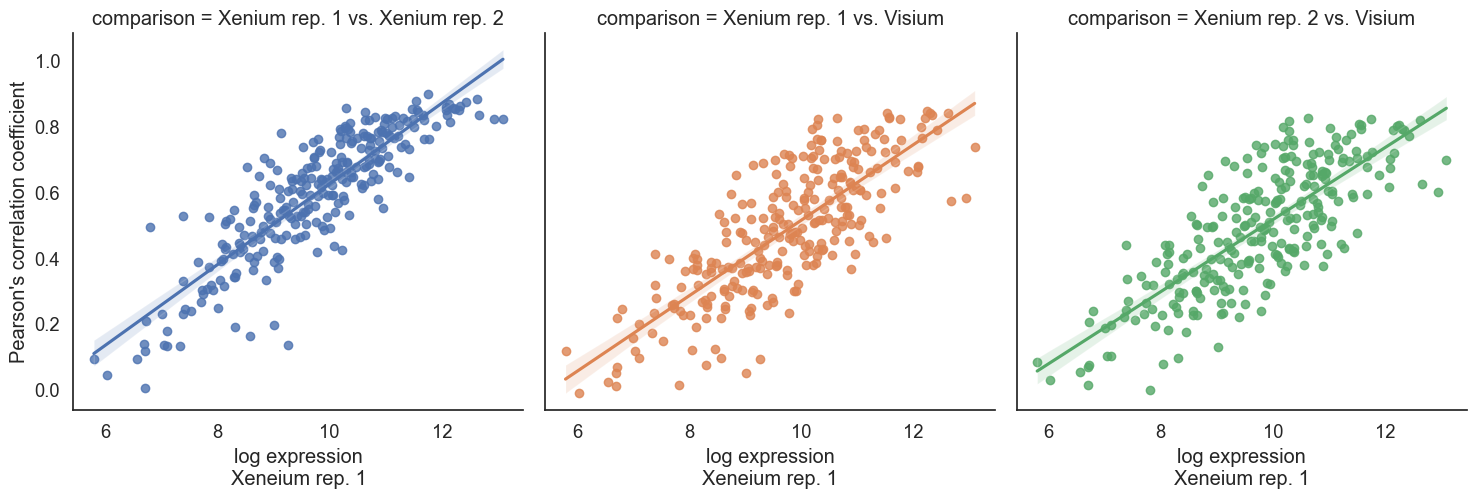

In [8]:
import seaborn as sns

sns.set(font_scale=1.2, rc={"figure.figsize": (5, 12)})
sns.set_style("white")
g = sns.lmplot(
    x="xe_rep1_counts", y="value", hue="comparison", col="comparison", data=df_melt, facet_kws={"legend_out": True}
)
g.set_axis_labels("log expression\nXeneium rep. 1", "Pearson's correlation coefficient")
plt.show()

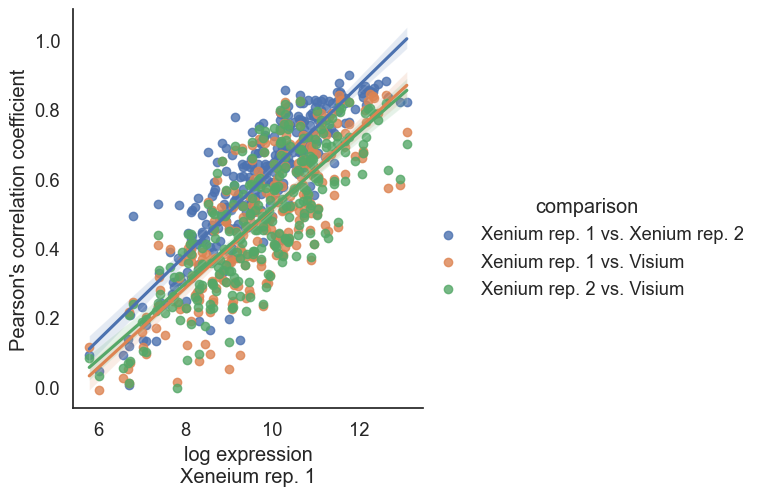

In [9]:
import seaborn as sns

sns.set(font_scale=1.2, rc={"figure.figsize": (5, 5), "font.size": 15})
sns.set_style("white")
g = sns.lmplot(x="xe_rep1_counts", y="value", hue="comparison", data=df_melt, facet_kws={"legend_out": True})
g.set_axis_labels("log expression\nXeneium rep. 1", "Pearson's correlation coefficient")
plt.show()

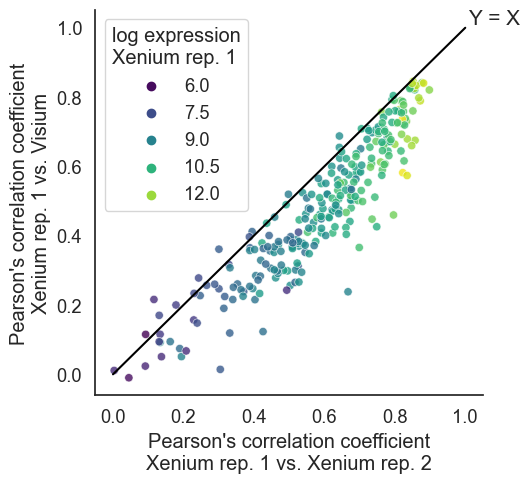

In [10]:
sns.set(font_scale=1.2, rc={"figure.figsize": (5, 5), "font.size": 15})
plt.rcParams.update({"font.size": 15})
sns.set_style("white")
g = sns.scatterplot(
    x="Xenium rep. 1 vs. Xenium rep. 2",
    y="Xenium rep. 1 vs. Visium",
    data=df,
    hue="xe_rep1_counts",
    palette="viridis",
    alpha=0.8,
)
plt.xlabel("Pearson's correlation coefficient\nXenium rep. 1 vs. Xenium rep. 2")
plt.ylabel("Pearson's correlation coefficient\nXenium rep. 1 vs. Visium")
xlims = (0, 1)
ylims = (0, 1)
g.plot(xlims, xlims, color="black")
g.text(1.01, 1.01, "Y = X")
sns.despine()
plt.legend(title="log expression\nXenium rep. 1")
plt.show()

In [11]:
ind = np.argmax(df["Xenium rep. 1 vs. Visium"].values)
max_gene = visium_roi_adata.var_names[ind]
ind = np.argmin(df["Xenium rep. 1 vs. Visium"].values)
min_gene = visium_roi_adata.var_names[ind]

In [12]:
min_gene

'UCP1'

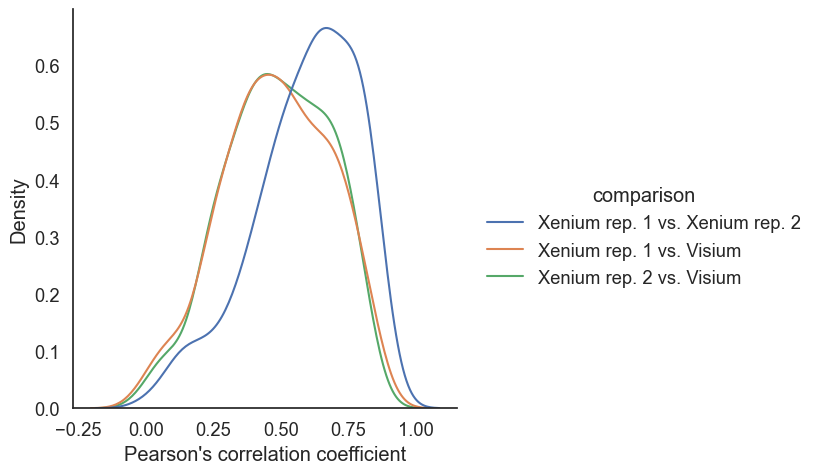

In [13]:
sns.set(font_scale=1.2, rc={"figure.figsize": (5, 5), "font.size": 15})
sns.set_style("white")
g = sns.displot(df_melt, x="value", hue="comparison", kind="kde")
g.set_axis_labels("Pearson's correlation coefficient")
plt.show()

In [14]:
visium_roi_adata

AnnData object with n_obs × n_vars = 2829 × 270
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'dataset', 'ROI', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial', 'spatialdata_attrs', 'wilcoxon'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_tx', 'xe_rep2_tx', 'counts'